In [1]:
import nbimporter
import numpy as np
import matplotlib.pyplot as plt
import Flux
import BalanceEquation
import PropertyConversion as prop
import MoistureConversion as mc

Importing Jupyter notebook from Flux.ipynb
Importing Jupyter notebook from BalanceEquation.ipynb
Importing Jupyter notebook from PropertyConversion.ipynb
Importing Jupyter notebook from MoistureConversion.ipynb
Importing Jupyter notebook from BentheimerSandstone.ipynb
Importing Jupyter notebook from vanGenuchten.ipynb


### 1次元モデルの差分計算をするためのモデュール

#### クラス：Cell( i )  
セルの位置と各種情報を合致させるためのクラス  

物理情報  
・i：セルの位置    
・dx：セルの大きさ  
・material：材料の種類  

環境情報  
・temp：温度  
・rh：相対湿度  
・miu：水分化学ポテンシャル  
・pv：水蒸気圧  

物性情報  
・crow：熱容量（比熱×密度）  
・lam：熱伝達率  
・phi：含水率
・dphi：含水率の水分化学ポテンシャル微分  
・ldp：透湿率  
・ldml：水分化学ポテンシャル勾配に対する液相水分伝導率

In [2]:
class  Cell():
    def __init__( self, i ):
        self.position = i
    
    # cell information
    def setMaterial( self, initial=0.0 ):
        self.material = initial
    
    def setDx( self, initial = 0.0 ):
        self.dx = initial 
    
    # initial condition
    def setTemp( self, initial = 0.0 ):
        self.temp = initial
    
    def setRH( self, initial=0.0  ):
        self.rh = initial
        
    def setMiu( self, initial=0.0 ):
        self.miu = initial
        
    def setPv( self, initial=0.0 ):
        self.pv = initial
        
    # physical property
    def setCRow( self, initial=0.0):
        self.crow = initial
    
    def setLAM( self, initial=0.0):
        self.lam = initial
        
    def setPhi( self, initial=0.0):
        self.phi = initial
    
    def setDPhi( self, initial=0.0):
        self.dphi = initial
        
    def setLDP(self,initial=0.0):
        self.ldp = initial
        
    def setLDML( self, initial=0.0):
        self.ldml = initial
    

In [3]:
# 使用例
c = [ Cell(i) for i in range(10)]

[ c[i].setDx(0.01*i) for i in range(10)] 
[ c[i].setTemp(293.16+i) for i in range(10)]  
[ c[i].setPv( mc.cal_RHtoPv( c[i].temp, 0.6 ) ) for i in range(10)] 

print(c[2].temp)

295.16


#### クラス：Differential( mns, pls )  
メッシュ間の差分情報を取得するクラス  
mns：前のセル情報  
pls：後のセル情報  
dtemp：セル間の温度差（前－後）  
dmoisture：セル間の水分量差（前－後）  
dx2：セルの質点間の距離（前－後）  

In [4]:
class Differential():
    def __init__( self, mns, pls ):
        self.mns = mns
        self.pls = pls
        
    # 質点間の距離
    def cal_Dx2( self, L ):
        if self.mns.position == 0:
            self.dx2 = self.mns.dx + self.pls.dx / 2.0
        elif self.pls.position == L-1:
            self.dx2 = self.mns.dx / 2.0 + self.pls.dx
        else :
            self.dx2 = self.mns.dx / 2.0 + self.pls.dx / 2.0
        
    def cal_DTemp( self ):
        self.temp = self.mns.temp - self.pls.temp
        
    def cal_DMiu( self ):
        self.miu = self.mns.miu - self.pls.miu
        
    def cal_DPv( self ):
        self.pv = self.mns.pv - self.pls.pv
    
    # 物性値の調和平均
    def cal_DLAM( self ):
        self.lam = ( self.mns.dx * self.mns.lam + self.pls.dx * self.pls.lam ) / ( self.mns.dx + self.pls.dx )
        
    def cal_DLDP( self ):
        self.ldp = ( self.mns.dx * self.mns.ldp + self.pls.dx * self.pls.ldp ) / ( self.mns.dx + self.pls.dx )
        
    def cal_DLDML( self ):
        self.ldml = ( self.mns.dx * self.mns.ldml + self.pls.dx * self.pls.ldml ) / ( self.mns.dx + self.pls.dx )
        

In [5]:
# 使用例
diff = [ Differential( c[i], c[i+1] ) for i in range ( 9 ) ]
[ diff[i].cal_Dx2( 10 ) for i in range( 9 ) ] 
diff[3].dx2

0.035

#### 第二種・第三種境界条件において材料境界と材料内の流量を結合する関数  
Flux：境界以外の流量  
StartFlux：端点（マイナス側）の流量  
EndFlux：端点（プラス側）の流量  
計算結果：[StartFlux + Flux + EndFlux ]

In [6]:
def sumFlux( Flux, StartFlux, EndFlux ):
    Flux = np.insert( Flux, 0, StartFlux)
    Flux = np.insert( Flux, (len(Flux)), EndFlux )
    return Flux

In [7]:
# 使用例
flux = np.array([1.0, 2.0, 1.0, 2.0])
startflux = 10.0
endflux = 20.0
sumFlux( flux, startflux, endflux)        

array([10.,  1.,  2.,  1.,  2., 20.])

####  クラス：Calculation( cell, diff )
ここでは気相は水蒸気圧で、液相は水分化学ポテンシャル勾配で移動するとした

コンストラクタ（__init__）:  
差分計算用に温湿度・物性情報を差分化する  

Flux():  
セル間の流量を計算する
流量自体は「クラス名.q」や「クラス名.j」で取得できる  

balanceEquation():  
セルにおける熱・水分の収支計算を行う  

replace():
セルの温度・水分情報の更新を行う


In [16]:
class Calculation():
    
    def __init__( self, cell, diff):
        
        self.L = len(cell)
        self.cell = cell
        self.diff = diff
        
        # 物性値の取得 
        pro  = [ prop.PhysicalProperty( cell[i].material, cell[i].temp, cell[i].miu )  for i in range(L)]
        [ cell[i].setCRow( pro[i].CRow() ) for i in range( L )]
        [ cell[i].setDPhi( pro[i].DPhi() ) for i in range( L )]
        [ cell[i].setLAM(  pro[i].LAM()  ) for i in range( L )]
        [ cell[i].setLDP(  pro[i].DP()  ) for i in range( L )]
        [ cell[i].setLDML( pro[i].LDML() ) for i in range( L )]

        # 差分計算 クラス：Differentialのコンストラクタで一括定義するほうが早い
        [ self.diff[i].cal_DTemp() for i in range( L-1 ) ] 
        [ self.diff[i].cal_DMiu()  for i in range( L-1 ) ] 
        [ self.diff[i].cal_DPv()   for i in range( L-1 ) ] 

        # 物性値の差分化
        [ self.diff[i].cal_DLAM() for i in range( L-1 ) ] 
        [ self.diff[i].cal_DLDP()  for i in range( L-1 ) ] 
        [ self.diff[i].cal_DLDML()   for i in range( L-1 ) ] 

    # 流量計算 
    def Flux( self, ALO, ALI, tempOut, tempIn, ALDPO, ALDPI, pvOut, pvIn ):
        # 熱流
        q_sol =  [ Flux.heatConduction( self.diff[i].lam, self.diff[i].temp, self.diff[i].dx2 )  for i in range(self.L-1) ]
        qmns = Flux.heatConvection( ALO, tempIn - self.cell[0].temp )       # 材料境界
        qpls = Flux.heatConvection( ALI, self.cell[L-1].temp - tempOut )   # 材料境界
        # 統合
        self.q = sumFlux( q_sol, qmns, qpls ) # 潜熱変化量入れてない

        # 水分流
        jv_sol = np.array( [Flux.vapourTransfer_pressure( self.diff[i].ldp, self.diff[i].pv, self.diff[i].dx2 ) for i in range( (self.L) - 1) ])  
        jl_sol = np.array( [Flux.liquidTransfer_potential( self.diff[i].ldml, self.diff[i].miu, self.diff[i].dx2, 0.0 ) for i in range( (self.L) - 1) ])
        jvmns = Flux.vapourConvection_pressure( ALDPO, pvIn - self.cell[0].pv )     # 材料境界
        jvpls = Flux.vapourConvection_pressure( ALDPO, self.cell[L-1].pv - pvOut )  # 材料境界
        # 統合
        self.j = sumFlux( jv_sol + jl_sol , jvmns, jvpls) #足すとき注意
        
    # 収支計算
    def balanceEquation( self ):
        balance = [ BalanceEquation.Calculation( self.cell[i].dx, dt ) for i in range(L)]
        
        # 熱収支
        self.dq    = [ ( self.q[i] - self.q[i+1]) for i in range(L) ]
        self.ntemp = [ balance[i].newtemp( self.cell[i].temp, self.dq[i], self.cell[i].crow ) for i in range(L) ]
        
        # 水分収支
        self.dj    = [ ( self.j[i] - self.j[i+1]) for i in range(L) ]
        self.nmiu  = [ balance[i].newmiu( self.cell[i].miu, self.dj[i], self.cell[i].dphi ) for i in range(L)  ]
        
    # 値の換算
    def replace( self):
        [ self.cell[i].setTemp( self.ntemp[i] ) for i in range( L ) ]
        [ self.cell[i].setMiu(  self.nmiu[i]  ) for i in range( L ) ]
        [ self.cell[i].setPv (  mc.cal_MiutoPv( self.ntemp[i], self.nmiu[i] ) ) for i in range( L ) ]
        [ self.cell[i].setRH (  mc.cal_MiutoRH( self.ntemp[i], self.nmiu[i] ) ) for i in range( L ) ]

### 値を取得するクラス  
#### クラス : logger()  
ある点の温度をlogging間隔ごとに取得するクラス  

#### クラス：CrossSection()  
ある時刻における全セルの状態を取得するクラス  

In [17]:
class CrossSection():
    def __init__( self, interval ):
        self.interval = interval
        self.times = []
        self.cell  = []
        
    def writeData( self, t, cell, dt):
        if t % self.interval == 0:
            self.times.append( t * dt)
            self.cell.append(cell)

### 計算  

#### 全体の流れ  

・壁体構成の入力（物性情報、セルの大きさ・個数、初期温湿度）  
・計算条件の入力（熱・水分の計算方法、境界条件）  
・計算に必要な物性値の決定

ループ計算内  

・物性値の取得→換算（差分型へ）  
・流量計算  
・収支計算→値の変換  
・値の取得（logging）  

終了　→　グラフ化など


In [59]:
L = 20
dt = 0.1

# 境界情報
#nx = np.array([0.0]*L)
tempIn = 290.15
tempOut = 295.15
pvIn = mc.cal_RHtoPv( tempIn, 0.78)
pvOut= mc.cal_RHtoPv( tempOut, 0.82)
ALO = 18.3+ 4.4
ALI = 4.9 + 4.4
ALDPO = 18.3 / ( 1005.0 * 1.205 * ( 8314.41 / 18.02 ) * 293.15 ) 
ALDPI = 4.9 / ( 1005.0 * 1.205 * ( 8314.41 / 18.02 ) * 293.15 ) 

# セル情報のセッティング

cell = [ Cell(i) for i in range( L ) ]
[ cell[i].setMaterial( 'BentheimerSandstone' )for i in range( L ) ]
[ cell[i].setDx( 0.001 )      for i in range( L ) ]
[ cell[i].setTemp( 293.16 )   for i in range( L ) ]
[ cell[i].setRH( 0.8 )        for i in range( L ) ]
[ cell[i].setMiu( mc.cal_RHtoMiu( cell[i].temp, cell[i].rh )) for i in range( L ) ]
[ cell[i].setPv(  mc.cal_RHtoPv(  cell[i].temp, cell[i].rh )) for i in range( L ) ]

# initialtemp is the initial temperatures at the cells in the wall
# surfCond is the surface conductance at the both side surface of the wall (W/m2K)
# composition is the material of the cells in the wall
# material_porp is the material property list written in the dictionary style

diff = [ Differential( cell[i], cell[i+1] ) for i in range (L-1) ]
[ diff[i].cal_Dx2( L ) for i in range( L-1 ) ] 

# logging情報  
log = CrossSection (60.0/dt)

print('Initialization')

Initialization


In [60]:
#%timeit
for i in range(10000):
    cal = Calculation(cell, diff)
    cal.Flux(ALO, ALI, tempOut, tempIn, ALDPO, ALDPI, pvOut, pvIn )
    cal.balanceEquation()
    cal.replace()
    log.writeData( i, cell, dt )

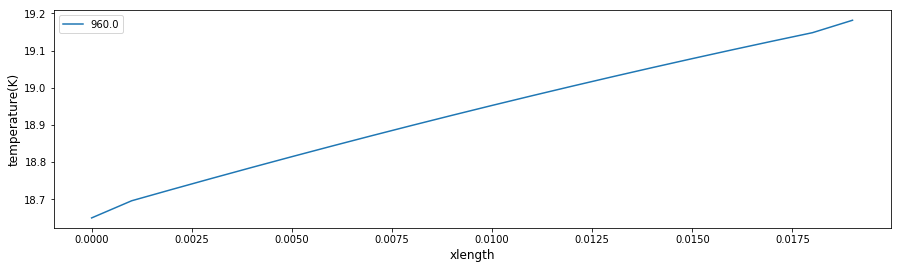

In [61]:
# 参考（相対湿度ー水分化学ポテンシャル関係）
# draw graph
time = len(log.times)
c = log.cell[time-1]
temp = [ c[i].temp-273.15 for i in range(L) ]
dx =   [ c[i].position*c[i].dx for i in range(L) ]

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
ax.plot( dx, temp , label = log.times[time-1] )
ax.set_xlabel( 'xlength', fontsize = 12 )
ax.set_ylabel( 'temperature(K)', fontsize = 12 )
plt.legend()
plt.show()
